In [21]:
import torch
import scipy.io as sio
from torch.utils import data
from torch import nn
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [22]:
train_data = sio.loadmat("data.mat")
X_data = train_data['X']
y_data = train_data['y']

train_features = torch.tensor(X_data, dtype=torch.float32)
train_labels = torch.tensor(y_data, dtype=torch.float32)*2 - 1

In [23]:
def data_iter(data_array, batch_size, is_train):
    datasets = data.TensorDataset(*data_array)
    return data.DataLoader(datasets, batch_size, shuffle=is_train)

In [24]:
num_features, num_labels = 2, 1
w = nn.Parameter(torch.normal(0, 0.1, size=(num_features, num_labels)), requires_grad=True)
b = nn.Parameter(torch.zeros(num_labels).reshape(-1, 1), requires_grad=True)

In [25]:
def linreg(X):
    return X @ w + b

In [26]:
def loss(y_hat, y):
    zero = torch.zeros_like(y_hat)
    return torch.max(zero, -1 * y * y_hat)

In [27]:
def train(train_iter, num_epochs, batch_size, lr, weight_decay):
    w_list, b_list, t_list = [w, ], [b, ], [0, ]
    train_loss = []
    optimizer = torch.optim.SGD([w, b], lr=lr, weight_decay=weight_decay)

    t = 1  # 迭代次数
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            y_hat = linreg(X)
            l = loss(y_hat, y)
            if l != 0:
                l.backward()
                optimizer.step()
                with torch.no_grad():
                    train_loss.append(l.sum())
                    w_list.append(w.detach().clone())
                    b_list.append(b.detach().clone())
                    t_list.append(t)
            t += 1
    return w_list, b_list, t_list
#     fig, ax = plt.subplots(figsize=(12, 8))
#     ax.plot(torch.arange(len(train_loss)), train_loss)
#     ax.set_xlabel("epochs")
#     ax.set_ylabel("loss")
#     plt.show()

In [28]:
num_epochs, batch_size, lr, weight_decay = 100, 1, 0.001, 0
train_iter = data_iter([train_features, train_labels], batch_size, True)

w_list, b_list, t_list = train(train_iter, num_epochs, batch_size, lr, weight_decay)

In [29]:
def net_toupiao(X):
    sum = 0.
    for i in range(1, len(t_list)):
        sum += (t_list[i] - t_list[i - 1]) * torch.sign(X @ w_list[i] + b_list[i])
    return torch.sign(sum)

def net_normal(X):
    return torch.sign(X @ w + b)

def accuary(net):
    acc, total = 0, 0
    for X, y in train_iter:
        acc += float((net(X) == y).type(y.dtype).sum())
        total += y.numel()
    return acc / total

# 在训练集上的拟合程度没有普通感知机好
print(f"net1 : {accuary(net_toupiao)}")
print(f"net2 : {accuary(net_normal)}")

net1 : 0.6470588235294118
net2 : 1.0


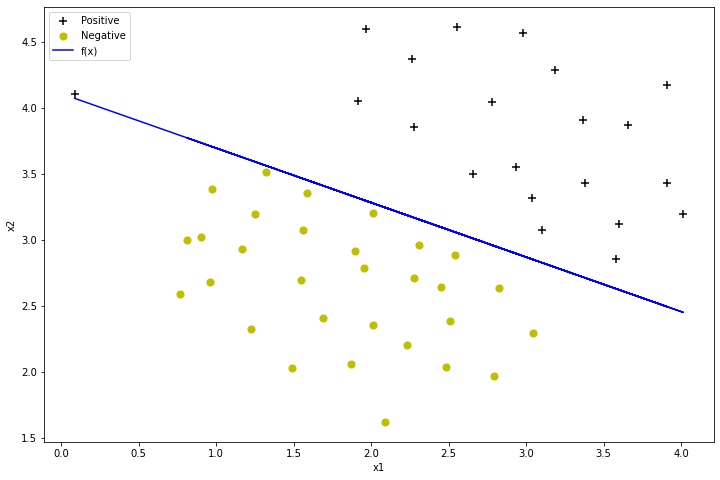

In [30]:
df = pd.DataFrame({'x1': X_data[:, 0], 'x2':X_data[:, 1], 'y':np.ravel(y_data)})

positive = df[df['y'].isin([1])]
negative = df[df['y'].isin([0])]

x1 = train_features[:, 0].reshape(-1, 1).detach()
x2 = ((w[0] * x1 + b) / (-1 * w[1])).detach()

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(positive['x1'], positive['x2'], color="black", s=50, marker='+', label="Positive")
ax.scatter(negative['x1'], negative['x2'], color="y", s=50, marker='o', label="Negative")
ax.plot(x1, x2, color="blue", label="f(x)")
ax.legend(loc=2)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
plt.show()